In [1]:
# !pip install numpy pandas matplotlib
%matplotlib inline

Found 20 CSV files:
result_0.csv
result_10.csv
result_20.csv
result_21.csv
result_30.csv
result_40.csv
result_50.csv
result_60.csv
result_70.csv
result_80.csv
result_90.csv
result_100.csv
result_110.csv
result_120.csv
result_130.csv
result_131.csv
result_140.csv
result_150.csv
result_160.csv
result_170.csv
Animation saved as sph_particles_velocity.mp4


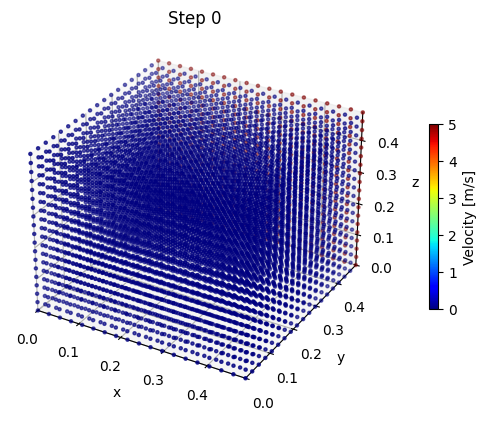

In [2]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

mp4_export = True

mp4_path = "sph_particles_velocity.mp4"


# 1. Load CSV files
def numerical_sort(value):
    """Extract the first number from filename for sorting."""
    numbers = re.findall(r"\d+", value)
    return int(numbers[0]) if numbers else -1


files = sorted(glob.glob("result_*.csv"), key=numerical_sort)
assert len(files) > 0, "CSV files not found"

print(f"Found {len(files)} CSV files:")
for f in files:
    print(f)

# 2. Read first file
df0 = pd.read_csv(files[0])

# Compute initial velocity
velocity = np.sqrt(df0["vx"] ** 2 + df0["vy"] ** 2 + df0["vz"] ** 2)

# 3. Prepare 3D figure
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Scatter with color by velocity magnitude
scat = ax.scatter(df0["x"], df0["y"], df0["z"], c=velocity, cmap="jet", s=5)  # type: ignore
cbar = fig.colorbar(scat, ax=ax, shrink=0.5, pad=0.1)
cbar.set_label("Velocity [m/s]")

ax.set_xlim(df0["x"].min(), df0["x"].max())
ax.set_ylim(df0["y"].min(), df0["y"].max())
ax.set_zlim(df0["z"].min(), df0["z"].max())
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
title = ax.set_title("Step 0")


# 4. Animation update function
def update(frame):
    """Update particle positions and color for given frame."""
    df = pd.read_csv(files[frame])
    # Update positions
    scat._offsets3d = (df["x"].values, df["y"].values, df["z"].values)  # type: ignore
    # Compute velocity magnitude for color
    velocity = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2 + df["vz"] ** 2)
    scat.set_array(velocity)  # Update colors
    step_num = re.findall(r"\d+", files[frame])[0]
    title.set_text(f"Step {step_num}")
    return (scat,)


# 5. Create animationD
if mp4_export:
    anim = FuncAnimation(fig, update, frames=len(files), interval=100, blit=False)

    # 6. Save animation as MP4
    # Make sure ffmpeg is installed: sudo apt install ffmpeg (WSL)
    anim.save(mp4_path, writer="ffmpeg", dpi=150)

    print(f"Animation saved as {mp4_path}")

Animation saved as sph_plane_velocity.mp4


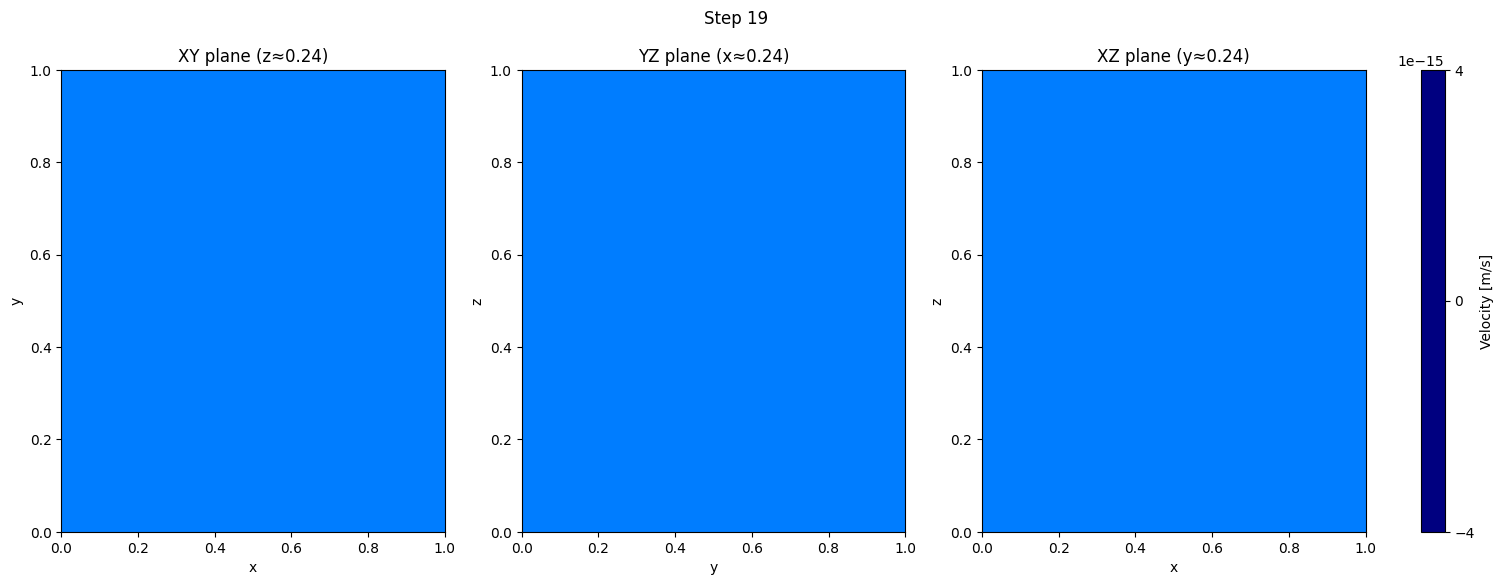

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
import glob
import re

mp4_export = True
mp4_path = "sph_plane_velocity.mp4"

# plane_slices: position along each axis as a percentage of the axis range (0~1)
plane_slices = {
    "x": 0.5,  # 50% along the X-axis
    "y": 0.5,  # 50% along the Y-axis
    "z": 0.5,  # 50% along the Z-axis
}


# Load CSV files sorted numerically
def numerical_sort(value):
    numbers = re.findall(r"\d+", value)
    return int(numbers[0]) if numbers else -1


files = sorted(glob.glob("result_*.csv"), key=numerical_sort)
assert len(files) > 0, "CSV files not found"

# Grid resolution for interpolation
grid_res = 100

# Create grids for each plane
XY_X, XY_Y = np.meshgrid(np.linspace(0, 1, grid_res), np.linspace(0, 1, grid_res))
YZ_Y, YZ_Z = np.meshgrid(np.linspace(0, 1, grid_res), np.linspace(0, 1, grid_res))
XZ_X, XZ_Z = np.meshgrid(np.linspace(0, 1, grid_res), np.linspace(0, 1, grid_res))

# Setup figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ["XY plane", "YZ plane", "XZ plane"]

# Create colorbar placeholder
contour_ref = axes[0].contourf(XY_X, XY_Y, np.zeros_like(XY_X), levels=50, cmap="jet")
cbar = fig.colorbar(
    contour_ref, ax=axes, orientation="vertical", fraction=0.025, pad=0.04
)
cbar.set_label("Velocity [m/s]")


# Init function
def init():
    for ax in axes:
        ax.contourf(XY_X, XY_Y, np.zeros_like(XY_X), levels=50, cmap="jet")
    return axes


# Automatically select plane positions
def get_slice_positions(df, plane_slices):
    x_min, x_max = df["x"].min(), df["x"].max()
    y_min, y_max = df["y"].min(), df["y"].max()
    z_min, z_max = df["z"].min(), df["z"].max()

    x_slice = x_min + plane_slices["x"] * (x_max - x_min)
    y_slice = y_min + plane_slices["y"] * (y_max - y_min)
    z_slice = z_min + plane_slices["z"] * (z_max - z_min)

    return x_slice, y_slice, z_slice


def update(frame):
    df = pd.read_csv(files[frame])
    vel_mag = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2 + df["vz"] ** 2)

    x_slice, y_slice, z_slice = get_slice_positions(df, plane_slices)

    # Tolerance for particle selection
    delta = df[["x", "y", "z"]].diff().median().median()
    tol = delta if not np.isnan(delta) and delta > 0 else 0.01

    # XY plane
    mask_xy = np.abs(df["z"] - z_slice) < tol
    points_xy = df.loc[mask_xy, ["x", "y"]].values
    values_xy = vel_mag[mask_xy]
    grid_xy = (
        griddata(points_xy, values_xy, (XY_X, XY_Y), method="linear", fill_value=0)
        if len(points_xy) > 0
        else np.zeros_like(XY_X)
    )

    # YZ plane
    mask_yz = np.abs(df["x"] - x_slice) < tol
    points_yz = df.loc[mask_yz, ["y", "z"]].values
    values_yz = vel_mag[mask_yz]
    grid_yz = (
        griddata(points_yz, values_yz, (YZ_Y, YZ_Z), method="linear", fill_value=0)
        if len(points_yz) > 0
        else np.zeros_like(YZ_Y)
    )

    # XZ plane
    mask_xz = np.abs(df["y"] - y_slice) < tol
    points_xz = df.loc[mask_xz, ["x", "z"]].values
    values_xz = vel_mag[mask_xz]
    grid_xz = (
        griddata(points_xz, values_xz, (XZ_X, XZ_Z), method="linear", fill_value=0)
        if len(points_xz) > 0
        else np.zeros_like(XZ_X)
    )

    # Clear axes and redraw
    for ax in axes:
        ax.cla()

    c1 = axes[0].contourf(XY_X, XY_Y, grid_xy, levels=50, cmap="jet")
    axes[0].set_title(f"XY plane (z≈{z_slice:.2f})")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    c2 = axes[1].contourf(YZ_Y, YZ_Z, grid_yz, levels=50, cmap="jet")
    axes[1].set_title(f"YZ plane (x≈{x_slice:.2f})")
    axes[1].set_xlabel("y")
    axes[1].set_ylabel("z")

    c3 = axes[2].contourf(XZ_X, XZ_Z, grid_xz, levels=50, cmap="jet")
    axes[2].set_title(f"XZ plane (y≈{y_slice:.2f})")
    axes[2].set_xlabel("x")
    axes[2].set_ylabel("z")

    # Update colorbar
    cbar.update_normal(c1)

    fig.suptitle(f"Step {frame}")
    return axes


if mp4_export:
    anim = FuncAnimation(fig, update, frames=len(files), interval=100, init_func=init)
    anim.save(mp4_path, writer="ffmpeg", dpi=150)
    print(f"Animation saved as {mp4_path}")